In [29]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [30]:
import os 

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 433.56it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


In [31]:
from skimage.transform import resize

# Lower the resolution of the images by a factor of 2
x_train_noisy = np.array([resize(image, (14,14), anti_aliasing=True) for image in x_train])
x_test_noisy = np.array([resize(image, (14,14), anti_aliasing=True) for image in x_test])

# Add very little Gaussian noise to the low-res training set
x_train_noisy = x_train_noisy.copy()
x_train_noisy = np.clip(x_train_noisy + np.random.normal(loc=0.0, scale=.1, size=x_train_noisy.shape), 0.0, 1.0)

# Add very little Gaussian noise to the low-res test set
x_test_noisy = x_test.copy()
x_test_noisy = np.clip(x_test_noisy + np.random.normal(loc=0.0, scale=.1, size=x_test_noisy.shape), 0.0, 1.0)


x_train_noisy = np.array([resize(image, (200,200), anti_aliasing=True) for image in x_train_noisy])
x_test_noisy = np.array([resize(image, (200,200), anti_aliasing=True) for image in x_test_noisy])

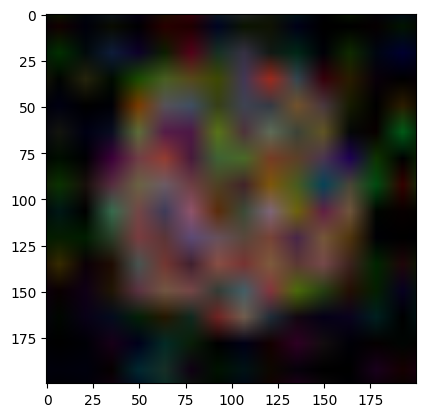

In [32]:
plt.imshow(x_train_noisy[1])
test_image = resize(x_train_noisy[1], (200,200), anti_aliasing=True)
plt.imshow(test_image)

In [33]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

# Load the saved model
model = tf.keras.models.load_model('/workspaces/Brain-Tumor-MRI-Classification/model-10-0.98-0.09.h5')

# Evaluate the model on the noisy test data
test_loss, test_acc = model.evaluate(x_test_noisy, y_test)

# Print the test accuracy
print('Test accuracy:', test_acc)

41/41 [==============================] - 36s 846ms/step - loss: 5.1994 - accuracy: 0.3127
Test accuracy: 0.3127383589744568


41/41 [==============================] - 36s 848ms/step


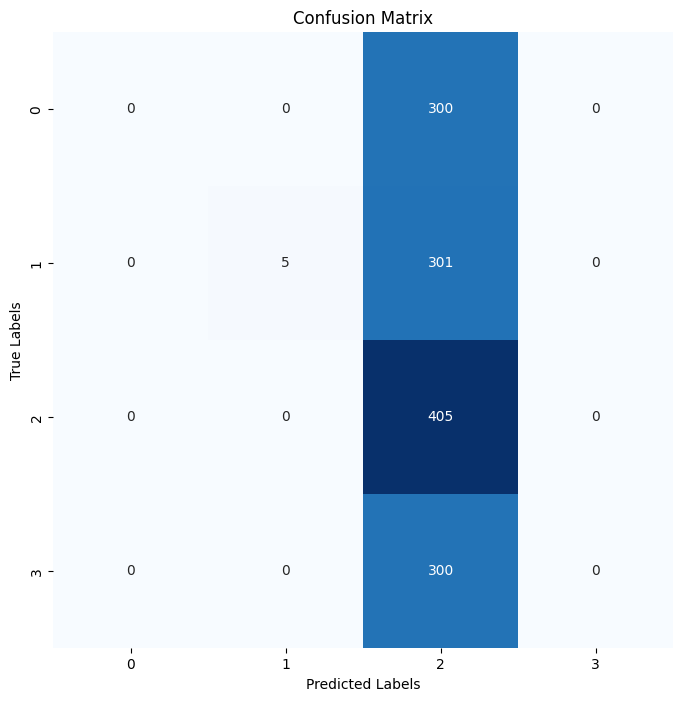

In [34]:
# Extract the predicted labels
y_pred = model.predict(x_test_noisy)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [35]:
x_train_noisy.shape

(5712, 200, 200, 3)

In [36]:
x_train.shape

(5712, 200, 200, 3)

In [37]:
#combine x_train and x_train_noisy and y_train and y_train
x_train = np.concatenate((x_train, x_train_noisy), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [38]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/5
286/286 [==============================] - 1358s 5s/step - loss: 0.1396 - accuracy: 0.5821 - val_loss: 0.1612 - val_accuracy: 0.5947
Epoch 2/5
286/286 [==============================] - 1336s 5s/step - loss: 0.0913 - accuracy: 0.7429 - val_loss: 0.2158 - val_accuracy: 0.4543
Epoch 3/5
286/286 [==============================] - 1333s 5s/step - loss: 0.0819 - accuracy: 0.7761 - val_loss: 0.0865 - val_accuracy: 0.7716
Epoch 4/5
286/286 [==============================] - 1334s 5s/step - loss: 0.0782 - accuracy: 0.7824 - val_loss: 0.0713 - val_accuracy: 0.8066
Epoch 5/5
286/286 [==============================] - 1331s 5s/step - loss: 0.0764 - accuracy: 0.7909 - val_loss: 0.0823 - val_accuracy: 0.7768


41/41 [==============================] - 34s 808ms/step


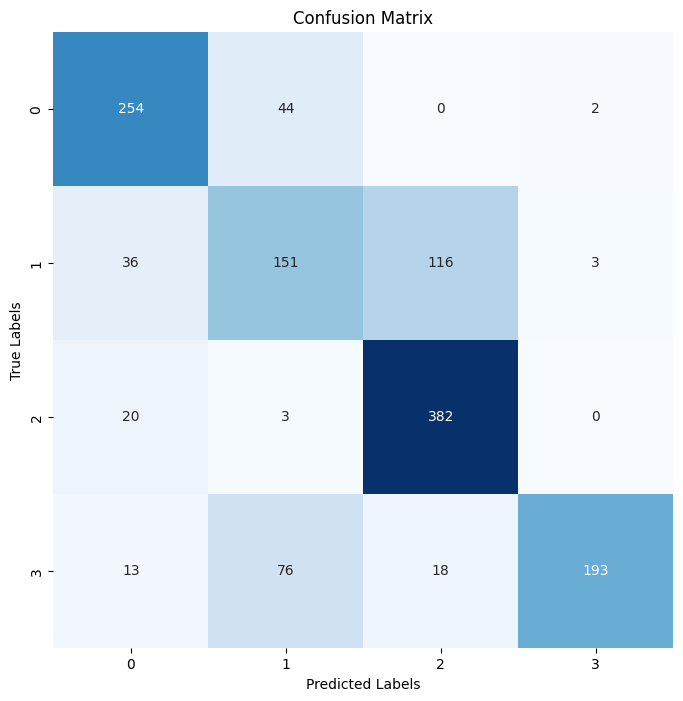

In [39]:
# Extract the predicted labels
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

41/41 [==============================] - 33s 804ms/step


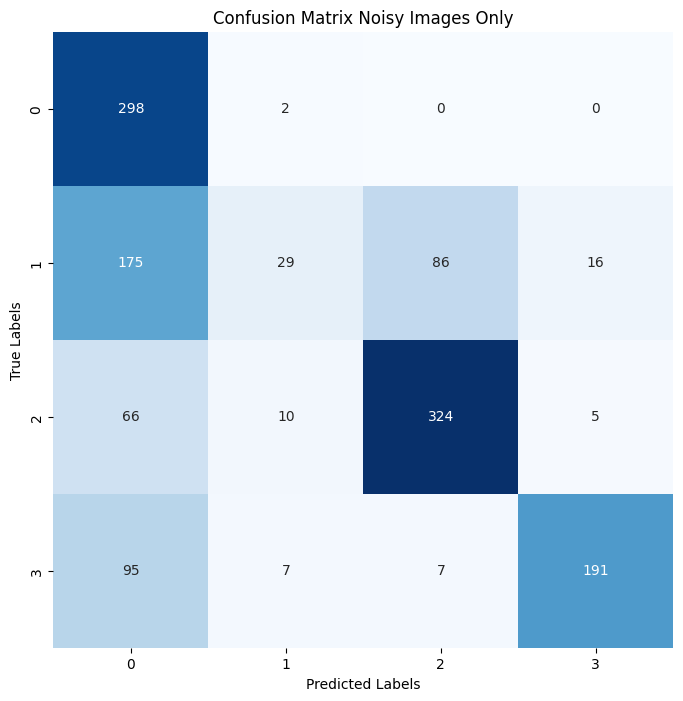

In [40]:
# Extract the predicted labels
y_pred = model.predict(x_test_noisy)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Noisy Images Only')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()